# Understanding Cyclistic Riders: Insights to Drive Membership Growth

As a junior data analyst on Cyclistic’s marketing analysis team, my role is to uncover actionable insights that will inform strategies to increase the company’s annual memberships. Cyclistic, a prominent bike-share company in Chicago, recognizes the critical role that annual members play in driving its long-term success. To support this objective, this report explores the differences in usage patterns between casual riders and annual members. By leveraging data-driven insights and professional visualizations, we aim to provide a solid foundation for designing targeted marketing strategies that convert casual riders into loyal members.

## Opening Question

#### Question we need to answer
- How do annual members and casual riders use Cyclistic bikes differently?
- Why would casual riders buy Cyclistic annual memberships?
- How can Cyclistic use digital media to influence casual riders to become members?

#### Questions to gain more insights
- How are the start and end points of riders distributed across different membership groups?
- What is the distribution of ride frequency across the months of the year for different membership groups?
- What is the distribution of ride frequency across the days of the week for different membership groups?
- What is the distribution of ride frequency across the hours of the day for different membership groups?
- What is the weekly ride frequency for different membership groups?
- What is the average travel distance for each membership group?
- What is the average ride duration for each membership group?

## Prepare data for analysis
Currently, the data is stored in different files, so we will consolidate them into a single table. We will use PostgreSQL for data aggregation and analysis. For large datasets with millions of rows, PostgreSQL performs better than Excel in terms of data analysis and manipulation.

### Create table for data store
Create a table to store raw data in preparation for future analysis.

```sql
create table tripdata
(
    ride_id            varchar(100) not null
        constraint tripdata_pk
            primary key,
    rideable_type      varchar(100),
    started_at         timestamp,
    ended_at           timestamp,
    start_station_name varchar(100),
    start_station_id   varchar(100),
    end_station_name   varchar(100),
    end_station_id     varchar(100),
    start_lat          double precision,
    start_lng          double precision,
    end_lat            double precision,
    end_lng            double precision,
    member_casual      varchar(50)
);
```



## Create a view to prepare for analysis.
### In the view, include the following information: ride_id, rideable_type, started_at, ended_at, start_station_name, end_station_name, start_lat, start_lng, end_lat, end_lng, member_casual, month, day, hour, distance, and duration_minutes.
#### To calculate the distance between the start and end points using the columns start_lat, start_lng, end_lat, and end_lng, we need to install the extension cube and the extension earthdistance.

```sql
CREATE EXTENSION IF NOT EXISTS cube;
CREATE EXTENSION IF NOT EXISTS earthdistance;
```
#### Adding columns beyond the existing data in the table helps us:
- We add the month column to determine how the ride frequency is distributed across the months of the year for different member groups.
- We add the day column to determine how the ride frequency is distributed across the days of the week for different member groups.
- We add the hour column to determine how the ride frequency is distributed across the hours of the day for different member groups.
- We add the distance column to determine the average distance traveled by each member group.
- We add the duration_minutes column to determine the average ride duration for each member group.
##### We remove the start_station_id and end_station_id columns because they are unnecessary and not used in the analysis.
```sql
create view tripdata_view
            (ride_id, rideable_type, started_at, ended_at, start_station_name, end_station_name, start_lat, start_lng,
             end_lat, end_lng, member_casual, month, day, hour, distance, duration_minutes)
as
SELECT ride_id,
       rideable_type,
       started_at,
       ended_at,
       start_station_name,
       end_station_name,
       start_lat,
       start_lng,
       end_lat,
       end_lng,
       member_casual,
       EXTRACT(month FROM started_at)                                                   AS month,
       EXTRACT(dow FROM started_at)                                                     AS day,
       EXTRACT(hour FROM started_at)                                                    AS hour,
       earth_distance(ll_to_earth(start_lat, start_lng), ll_to_earth(end_lat, end_lng)) AS distance,
       EXTRACT(epoch FROM ended_at - started_at) / 60::numeric                          AS duration_minutes
FROM tripdata;
```

## Insert data to database
I will use two libraries, psycopg2 and pandas, to read data from a CSV file and save it to the database.

Firstly, we install psycopg2 and pandas:
```
pip install psycopg2 pandas
```

Next, let start insert data to database:

Some lat lng data is empty, we will remove these row

We got key duplicate error, so we will create a temp table to store duplicate data first named tripdata_temp

```sql
create table tripdata_temp
(
    ride_id            varchar(100) not null,
    rideable_type      varchar(100),
    started_at         timestamp,
    ended_at           timestamp,
    start_station_name varchar(100),
    start_station_id   varchar(100),
    end_station_name   varchar(100),
    end_station_id     varchar(100),
    start_lat          double precision,
    start_lng          double precision,
    end_lat            double precision,
    end_lng            double precision,
    member_casual      varchar(50)
);
```

In [9]:
import psycopg2
import pandas as pd
import os

# Config PostgreSQL
db_config = {
    "dbname": "cyclist",
    "user": "postgres",
    "password": "admin",
    "host": "localhost",
    "port": 5432        
}

# path
csv_dir = "./data"

try:
    # connect db
    conn = psycopg2.connect(**db_config)
    cursor = conn.cursor()        
    for filename in os.listdir(csv_dir):
        # open with pandas
        df = pd.read_csv("./data/" + filename)
        # clean null data
        df.dropna(subset=['start_lat', 'start_lng', 'end_lng', 'end_lat'], inplace=True)
        # save csv
        df.to_csv("./data/" + filename, index=False)
        # open csv file
        with open(csv_dir + '/' + filename, 'r') as f:
            next(f) # ignore header
            # copy from cvs to database table
            cursor.copy_from(f, 'tripdata_temp', sep=',', columns=(
    'ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual'))
    # save the change
    conn.commit()
    print("Data insert successful")

except Exception as e:
    print(f"Error: {e}")

finally:
    if conn:
        cursor.close()
        conn.close()


Data insert successful


## Insert data to tripdata table

We insert data to tripdata table and ignore duplicate data by ride_id

```SQl
INSERT INTO tripdata
SELECT *
FROM tripdata_temp
ON CONFLICT (ride_id) DO NOTHING;
```

## Start analyse data

Let start answer question using view table

### How are the start and end points of riders distributed across different membership groups?

To answer the question above, we will extract 10 data points for each membership group, calculated from the starting points to the endpoints with the highest number of trips.

First, we will process the data for casual customers.
```sql
with visited_location as (
  (Select start_station_name as location from tripdata_view 
                                         where start_station_name != '' 
                                           and member_casual = 'casual')
  union all
  (Select end_station_name as location from tripdata_view 
                                       where end_station_name != '' 
                                         and  member_casual = 'casual')
)

Select location, count(location) as total from visited_location
group by location order by total desc limit 10
```

Result:

| Location                                | Total   |
|-----------------------------------------|---------|
| Streeter Dr & Grand Ave                 | 105,641 |
| DuSable Lake Shore Dr & Monroe St       | 65,887  |
| Michigan Ave & Oak St                   | 50,849  |
| DuSable Lake Shore Dr & North Blvd      | 49,632  |
| Millennium Park                         | 46,763  |
| Shedd Aquarium                          | 39,993  |
| Dusable Harbor                          | 35,124  |
| Theater on the Lake                     | 34,913  |
| Michigan Ave & 8th St                   | 25,839  |
| Adler Planetarium                       | 23,944  |


Next, we will process the data for member customers.
```sql
with visited_location as (
  (Select start_station_name as location from tripdata_view 
                                         where start_station_name != '' 
                                           and member_casual = 'member')
  union all
  (Select end_station_name as location from tripdata_view 
                                       where end_station_name != '' 
                                         and  member_casual = 'member')
)

Select location, count(location) as total from visited_location
group by location order by total desc limit 10
```

Result:

| Location                                | Total   |
|-----------------------------------------|---------|
| Kingsbury St & Kinzie St                | 59,215  |
| Clinton St & Washington Blvd            | 56,181  |
| Clinton St & Madison St                 | 50,887  |
| Clark St & Elm St                       | 49,432  |
| Wells St & Concord Ln                   | 41,487  |
| Wells St & Elm St                       | 40,801  |
| Clinton St & Jackson Blvd               | 40,743  |
| State St & Chicago Ave                  | 38,806  |
| Canal St & Madison St                   | 38,366  |
| University Ave & 57th St                | 38,339  |

Summary:
The locations in the upper section of casual riders are mainly focused on tourism, entertainment, culture, and nature, often near Lake Michigan. These areas, such as Millennium Park and Shedd Aquarium, attract tourists and provide outdoor spaces, parks, and cultural events. They are ideal for recreation and relaxation, with a vibrant atmosphere that caters to those looking to explore and enjoy the city's beauty.

In contrast, the locations in the lower section of member riders are situated in the city’s commercial and transportation hubs. These areas, like Clinton St & Washington Blvd and State St & Chicago Ave, are centers of business and transit, primarily serving residents and commuters. They focus on economic activity, with many office buildings, retail spaces, and major transit connections.

The key difference lies in their purpose: the upper section caters to leisure, tourism, and outdoor activities, while the lower section supports commerce, transportation, and daily commuting.

### What is the distribution of ride frequency across the months of the year for different membership groups?

We will summarize the trip data by month for each customer group.

First, with casual group:
```sql
Select month, count(ride_id) from tripdata_view 
where member_casual = 'casual' group by month order by month
```

| Month | Total   |
|-------|---------|
| 1     | 120,176 |
| 2     | 175,914 |
| 3     | 218,977 |
| 4     | 283,509 |
| 5     | 378,274 |
| 6     | 409,539 |
| 7     | 428,375 |
| 8     | 437,177 |
| 9     | 474,311 |
| 10    | 399,503 |
| 11    | 241,412 |
| 12    | 140,317 |

Next, with member group:
```sql
Select month, count(ride_id) from tripdata_view 
where member_casual = 'member' group by month order by month
```

| Month | Total   |
|-------|---------|
| 1     | 23,977  |
| 2     | 46,990  |
| 3     | 82,230  |
| 4     | 131,632 |
| 5     | 230,994 |
| 6     | 299,863 |
| 7     | 319,580 |
| 8     | 318,295 |
| 9     | 345,057 |
| 10    | 215,794 |
| 11    | 92,632  |
| 12    | 38,637  |

Next, we visualize the data

First, we install the matplotlib library

```
pip install matplotlib
```


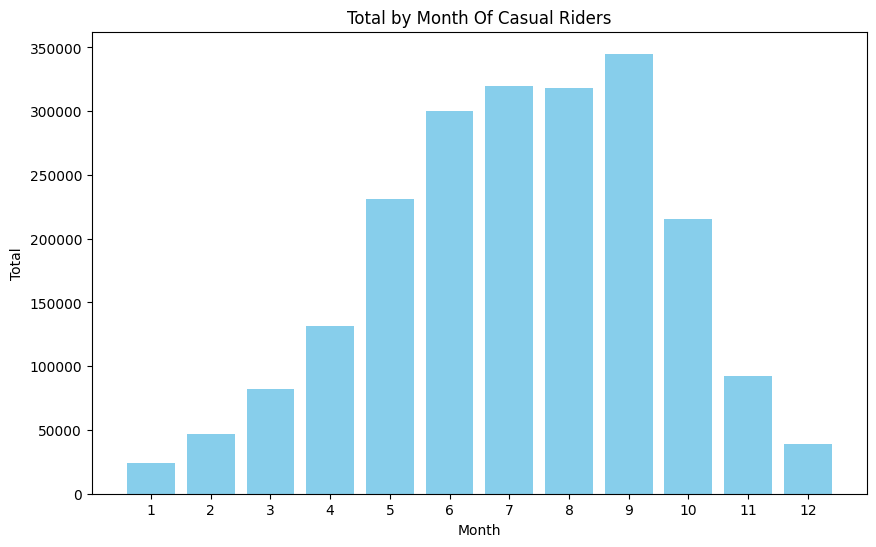

In [4]:
import matplotlib.pyplot as plt

# Data
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
totals = [23977, 46990, 82230, 131632, 230994, 299863, 319580, 318295, 345057, 215794, 92632, 38637]

# Plotting the bar chart
plt.figure(figsize=(10,6))
plt.bar(months, totals, color='skyblue')
plt.xlabel('Month')
plt.ylabel('Total')
plt.title('Total by Month Of Casual Riders')
plt.xticks(months)
plt.show()

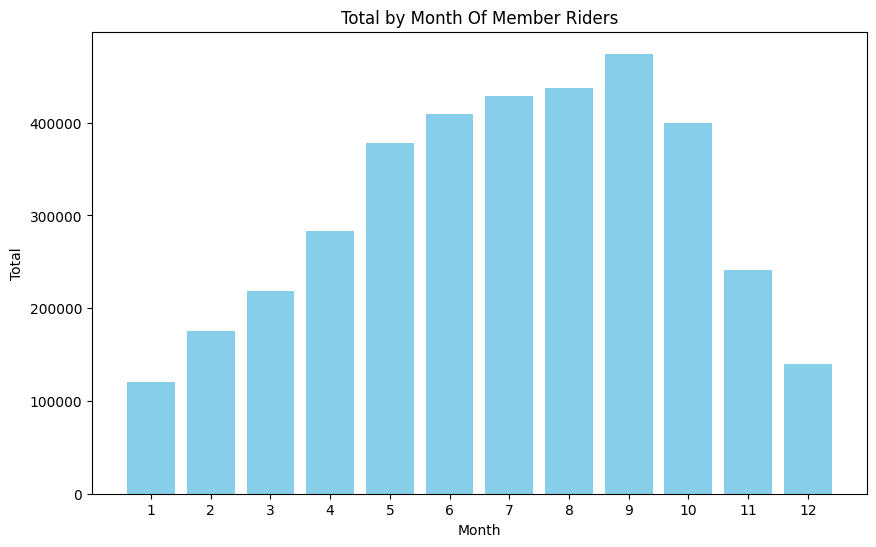

In [5]:
import matplotlib.pyplot as plt

# Data
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
totals = [120176, 175914, 218977, 283509, 378274, 409539, 428375, 437177, 474311, 399503, 241412, 140317]

# Plotting the bar chart
plt.figure(figsize=(10,6))
plt.bar(months, totals, color='skyblue')
plt.xlabel('Month')
plt.ylabel('Total')
plt.title('Total by Month Of Member Riders')
plt.xticks(months)
plt.show()

Looking at the two charts, we can see that the months from June to September are the busiest in terms of the number of visitors.

From June to September, the number of bicycle riders in Chicago is significantly higher compared to other months. This trend is evident for both casual riders and member riders, with the peak usage occurring in these months.

The primary reason for this increase is the weather. Chicago experiences warm and pleasant temperatures during summer (around 20–30°C), making it ideal for outdoor activities such as cycling. In contrast, winter months (December to February) are extremely cold, with frequent snow and temperatures below freezing, which discourages cycling.

Additionally, summer is the peak tourist season in Chicago. Visitors often use bicycles to explore popular attractions like Lake Michigan, Millennium Park, and bike-friendly routes. The city also hosts numerous outdoor events and festivals during this time, further boosting bicycle usage.

Conversely, in the colder months, shorter daylight hours and busy work or school schedules reduce the frequency of bike usage. The challenging weather conditions make other modes of transportation more favorable.

In summary, the combination of favorable weather, high tourism activity, and summer events makes June to September the most active period for bicycle riders in Chicago, while the winter months see a significant decline.

Data shows that from December to February, member riders account for 11.77% of the total yearly member rides, while casual riders only account for 5.1% of the total yearly casual rides. The higher number of rides by member riders compared to casual riders during the winter months can be explained by several factors: Member riders use bikes as a daily mode of transport, while casual riders use bikes for leisure, making them less likely to ride in cold weather. Member riders are also committed to their membership, whereas casual riders are not. Additionally, the harsh winter climate reduces outdoor activities, especially for casual riders.

## What is the distribution of ride frequency across the days of the week for different membership groups?

We will summarize data by days of week

First, with casual group:
```sql
Select CASE day
           WHEN 0 THEN 'Sunday'
           WHEN 1 THEN 'Monday'
           WHEN 2 THEN 'Tuesday'
           WHEN 3 THEN 'Wednesday'
           WHEN 4 THEN 'Thursday'
           WHEN 5 THEN 'Friday'
           WHEN 6 THEN 'Saturday'
       END AS day_name, count(ride_id) as total 
from tripdata_view 
where tripdata_view.member_casual = 'casual' group by day order by day
```

| Day Name   | Total   |
|------------|---------|
| Sunday     | 351841  |
| Monday     | 251021  |
| Tuesday    | 232092  |
| Wednesday  | 270098  |
| Thursday   | 266757  |
| Friday     | 326183  |
| Saturday   | 447689  |


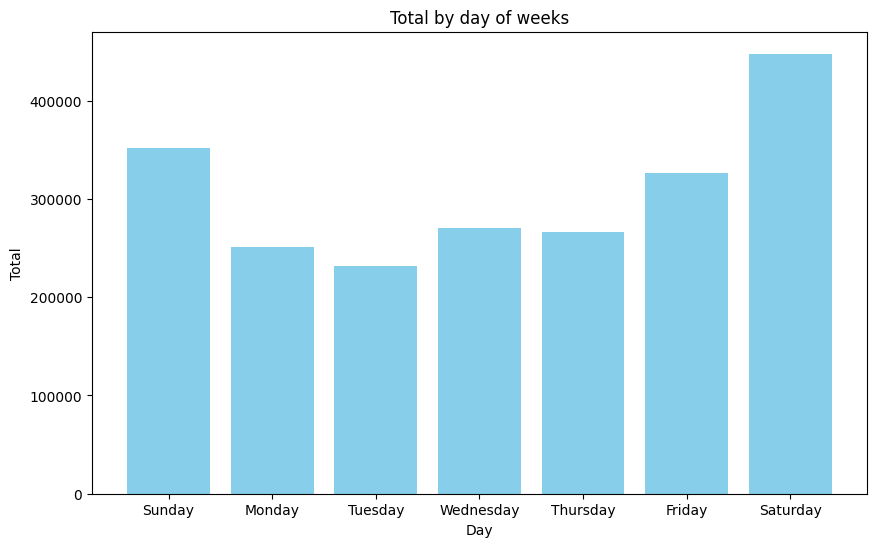

In [1]:
import matplotlib.pyplot as plt

# Data
day_name = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
total = [351841, 251021, 232092, 270098, 266757, 326183, 447689]

# Plotting the bar chart
plt.figure(figsize=(10,6))
plt.bar(day_name, total, color='skyblue')
plt.xlabel('Day')
plt.ylabel('Total')
plt.title('Total by day of weeks')
plt.xticks(day_name)
plt.show()


Next, with member group:
```sql
Select CASE day
           WHEN 0 THEN 'Sunday'
           WHEN 1 THEN 'Monday'
           WHEN 2 THEN 'Tuesday'
           WHEN 3 THEN 'Wednesday'
           WHEN 4 THEN 'Thursday'
           WHEN 5 THEN 'Friday'
           WHEN 6 THEN 'Saturday'
       END AS day_name, count(ride_id) as total 
from tripdata_view 
where tripdata_view.member_casual = 'member' group by day order by day
```
| Day Name   | Total   |
|------------|---------|
| Sunday     | 421125  |
| Monday     | 536334  |
| Tuesday    | 570800  |
| Wednesday  | 607683  |
| Thursday   | 569562  |
| Friday     | 522666  |
| Saturday   | 479314  |

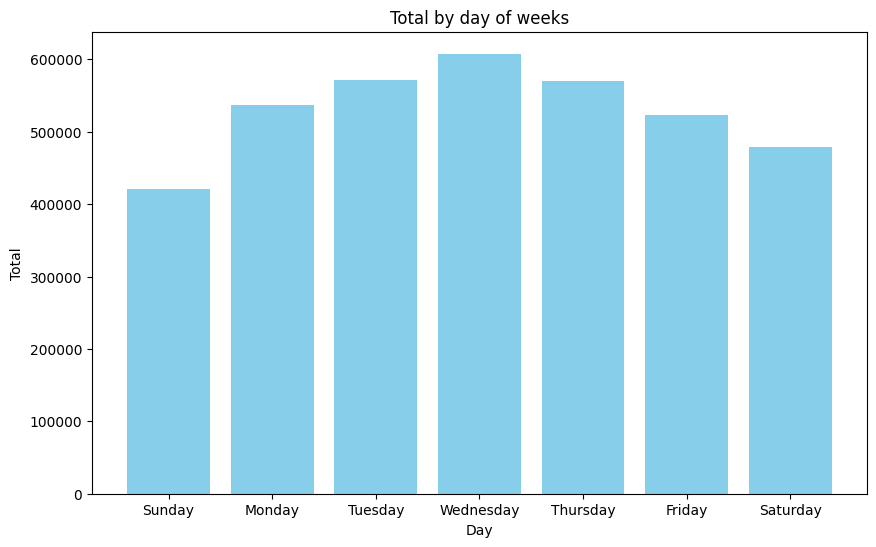

In [2]:
import matplotlib.pyplot as plt

# Data
day_name = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
total = [421125, 536334, 570800, 607683, 569562, 522666, 479314]

# Plotting the bar chart
plt.figure(figsize=(10,6))
plt.bar(day_name, total, color='skyblue')
plt.xlabel('Day')
plt.ylabel('Total')
plt.title('Total by day of weeks')
plt.xticks(day_name)
plt.show()

### Conclusion:

The two charts illustrate the weekly trip counts for two groups of users in Chicago: casual users and members. Casual users show the highest trip counts on Saturday, followed by Sunday, indicating their preference for using the service on weekends. In contrast, members have the highest activity on Wednesday, followed by Tuesday and Thursday, which fall on weekdays. This difference reflects distinct user behaviors.

Casual users, likely tourists or occasional riders, prioritize leisure and recreational trips, making weekends the peak period for their service usage. These users are less consistent and tend to ride when they have more free time. On the other hand, members are more regular riders who rely on the service primarily for commuting purposes during the workweek. Their activity peaks midweek, likely aligning with their work schedules and daily routines.

The disparity between the two groups highlights their unique travel patterns. While casual users benefit from convenient weekend accessibility, members require reliable service during weekdays for consistent use. Understanding these differences allows service providers to tailor their offerings, ensuring adequate availability and resources during peak times for each group. This segmentation provides valuable insights for improving service efficiency and meeting user expectations.

## What is the distribution of ride frequency across the hours of the day for different membership groups?

We will summarize data by hours of day

First, with casual group:

```sql
select  hour, count(hour) as total from tripdata_view 
where member_casual='casual' group by  hour order by hour
```

| Hour | Total    |
|------|----------|
| 0    | 35277    |
| 1    | 23607    |
| 2    | 14643    |
| 3    | 8137     |
| 4    | 6404     |
| 5    | 12108    |
| 6    | 28715    |
| 7    | 53428    |
| 8    | 75646    |
| 9    | 76454    |
| 10   | 94227    |
| 11   | 120035   |
| 12   | 142046   |
| 13   | 148163   |
| 14   | 154348   |
| 15   | 169704   |
| 16   | 190993   |
| 17   | 203497   |
| 18   | 173515   |
| 19   | 127919   |
| 20   | 93567    |
| 21   | 77834    |
| 22   | 67924    |
| 23   | 47490    |



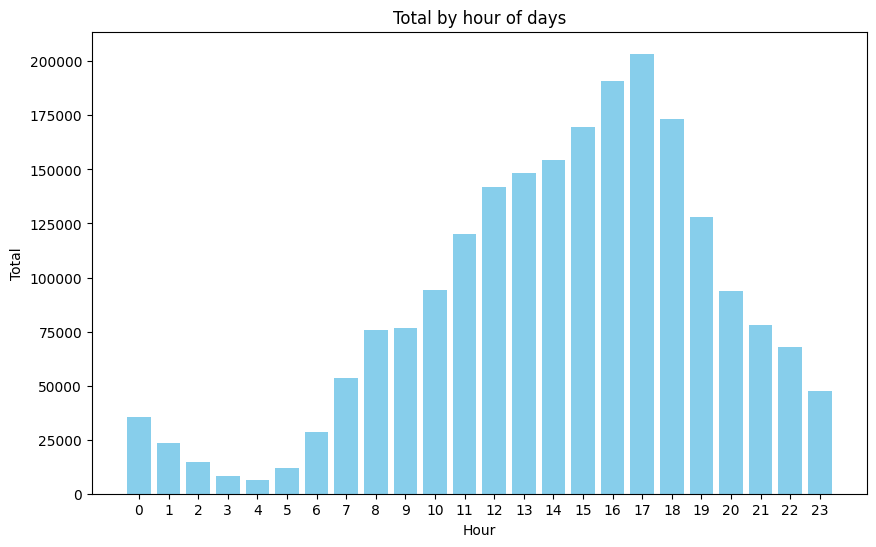

In [7]:
import matplotlib.pyplot as plt

# Data
hour = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
total = [35277,23607,14643,8137,6404,12108,28715, 53428,75646,76454,94227,120035,142046,148163,154348,169704,190993,203497,173515,127919,93567,77834,67924,47490]
# Plotting the bar chart
plt.figure(figsize=(10,6))
plt.bar(hour, total, color='skyblue')
plt.xlabel('Hour')
plt.ylabel('Total')
plt.title('Total by hour of days')
plt.xticks(hour)
plt.show()

In [11]:
print(sum([35277,23607,14643,8137,6404,12108,28715, 53428,75646,76454,94227,120035,142046,148163,154348,169704,190993,203497,173515,127919,93567,77834,67924,47490]))

2145681


Next, with member group:

```sql
select  hour, count(hour) as total from tripdata_view 
where member_casual='member' group by  hour order by hour
```

| Hour | Total    |
|------|----------|
| 0    | 32747    |
| 1    | 20083    |
| 2    | 11384    |
| 3    | 7821     |
| 4    | 8711     |
| 5    | 34597    |
| 6    | 104017   |
| 7    | 200343   |
| 8    | 255257   |
| 9    | 173818   |
| 10   | 153221   |
| 11   | 178947   |
| 12   | 204697   |
| 13   | 204586   |
| 14   | 204930   |
| 15   | 251126   |
| 16   | 342969   |
| 17   | 393085   |
| 18   | 306598   |
| 19   | 215091   |
| 20   | 150792   |
| 21   | 115832   |
| 22   | 83952    |
| 23   | 52880    |


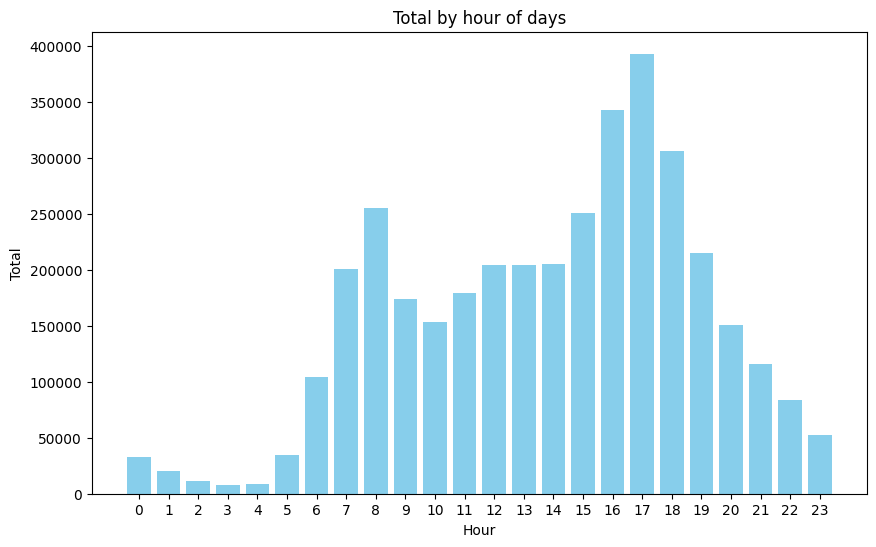

In [8]:
import matplotlib.pyplot as plt

# Data
hour = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
total = [32747,20083,11384,7821,8711,34597,104017,200343,255257,173818,153221,178947,204697,204586,204930,251126,342969,393085,306598,215091,150792,115832,83952,52880]
# Plotting the bar chart
plt.figure(figsize=(10,6))
plt.bar(hour, total, color='skyblue')
plt.xlabel('Hour')
plt.ylabel('Total')
plt.title('Total by hour of days')
plt.xticks(hour)
plt.show()

In [12]:
print(sum([32747,20083,11384,7821,8711,34597,104017,200343,255257,173818,153221,178947,204697,204586,204930,251126,342969,393085,306598,215091,150792,115832,83952,52880]))

3707484


In [13]:
print(sum([3707484, 2145681]))

5853165
